# Data Loading and Preprocessing

In [1]:
import numpy as np
import os
import cv2
import open3d as o3d
#import open3d.visualization.jupyter as o3d_jupyter
import pykitti
import torch
import threading
from ultralytics import YOLO
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from sklearn.cluster import DBSCAN
from filterpy.kalman import KalmanFilter
import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Define KITTI Dataset Directory (Based on Your Structure)
BASE_DIR = "/home/umusa/JMODT/data/tracking"
TRAINING_DIR = f"{BASE_DIR}/training"
TESTING_DIR = f"{BASE_DIR}/testing"

In [3]:
# # Function to Load a KITTI Frame (Camera + LiDAR)
# def load_kitti_frame(frame_idx, split="training"):
#     if split == "training":
#         data_dir = TRAINING_DIR
#     else:
#         data_dir = TESTING_DIR

#     # Load Camera Image
#     img_path = f"{data_dir}/image_02/{str(frame_idx).zfill(6)}.png"
#     img = cv2.imread(img_path)

#     # Load LiDAR Point Cloud
#     lidar_path = f"{data_dir}/velodyne/{str(frame_idx).zfill(6)}.bin"
#     lidar_data = np.fromfile(lidar_path, dtype=np.float32).reshape(-1, 4)[:, :3]  # Extract (x, y, z)

#     return img, lidar_data

In [4]:
def load_kitti_frame(frame_idx, sequence="0010", split="training"):
    """
    Load a KITTI frame (Camera + LiDAR) while handling subdirectories (0000 - 0020).
    
    Args:
    - frame_idx (int): The frame index (e.g., 10).
    - sequence (str): The subdirectory sequence (e.g., '0010').
    - split (str): 'training' or 'testing'.

    Returns:
    - img (numpy array): Loaded camera image.
    - lidar_data (numpy array): Loaded LiDAR point cloud (Nx3).
    """

    # Define base dataset directory
    #BASE_DIR = "/home/umusa/JMODT/data/tracking"
    DATA_DIR = f"{BASE_DIR}/{split}"

    # Construct correct file paths
    img_path = f"{DATA_DIR}/image_02/{sequence}/{str(frame_idx).zfill(6)}.png"
    lidar_path = f"{DATA_DIR}/velodyne/{sequence}/{str(frame_idx).zfill(6)}.bin"

    # Ensure files exist
    if not os.path.exists(img_path):
        raise FileNotFoundError(f"Camera image not found: {img_path}")
    if not os.path.exists(lidar_path):
        raise FileNotFoundError(f"LiDAR file not found: {lidar_path}")

    # Load Camera Image
    img = cv2.imread(img_path)

    # Load LiDAR Point Cloud
    lidar_data = np.fromfile(lidar_path, dtype=np.float32).reshape(-1, 4)[:, :3]  # Extract (x, y, z)

    return img, lidar_data

In [5]:
# Example: Load Frame 10 from sequence 0010 (Training Set)
img, lidar = load_kitti_frame(10, sequence="0010", split="training")

In [6]:
# # Display Camera Image
# cv2.imshow("KITTI Camera", img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

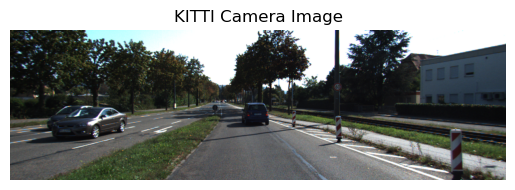

In [7]:
# Display Image Using Matplotlib
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct colors
plt.axis("off")
plt.title("KITTI Camera Image")
plt.show()

In [8]:
# # Display LiDAR Data
# import open3d as o3d
# pcd = o3d.geometry.PointCloud()
# pcd.points = o3d.utility.Vector3dVector(lidar)
# o3d.visualization.draw_geometries([pcd])

In [9]:
from mpl_toolkits.mplot3d import Axes3D

# Reduce LiDAR points for faster plotting
lidar_sample = lidar[:10000]  

# Extract X, Y, Z
x, y, z = lidar_sample[:, 0], lidar_sample[:, 1], lidar_sample[:, 2]

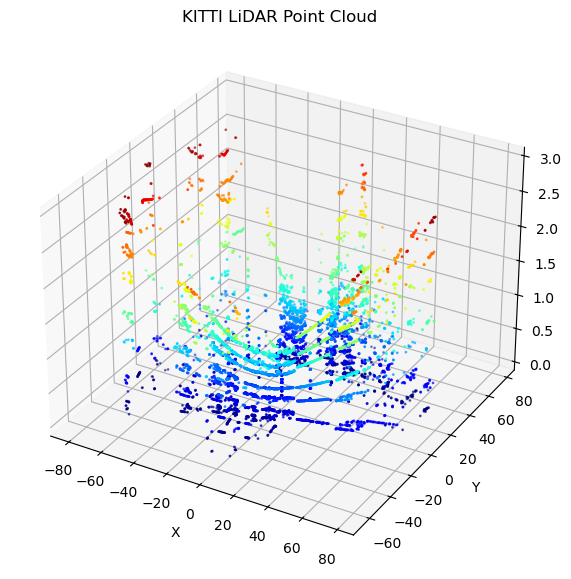

In [10]:
# Plot in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x, y, z, s=1, c=z, cmap="jet", marker="o")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("KITTI LiDAR Point Cloud")
plt.show()

In [11]:
# pcd = o3d.geometry.PointCloud()
# pcd.points = o3d.utility.Vector3dVector(lidar[:5000])  # Reduce point count

# o3d.visualization.draw_geometries([pcd])

# Overlaying LiDAR on Camera Image

In [12]:
# Load KITTI Calibration Data
def load_calibration(sequence="0010"):
    calib_file = f"{TRAINING_DIR}/calib/{sequence}.txt"
    with open(calib_file, "r") as f:
        lines = f.readlines()

    # Get Projection Matrix P2 (Camera 2)
    P2 = np.array([float(x) for x in lines[2].split()[1:]]).reshape(3, 4)

    # Get R0_rect (Rectification Matrix)
    R0_rect = np.array([float(x) for x in lines[4].split()[1:]]).reshape(3, 3)

    # Get Tr_velo_to_cam (LiDAR to Camera Transformation)
    Tr_velo_to_cam = np.array([float(x) for x in lines[5].split()[1:]]).reshape(3, 4)

    return P2, R0_rect, Tr_velo_to_cam

In [13]:
# Load Calibration Matrices
P2, R0_rect, Tr_velo_to_cam = load_calibration(sequence="0010")

In [14]:
def project_lidar_to_camera(lidar_points, P2, R0_rect, Tr_velo_to_cam):
    """
    Projects 3D LiDAR points onto the 2D camera image frame.
    """
    # Convert LiDAR points to homogeneous coordinates
    lidar_hom = np.hstack((lidar_points, np.ones((lidar_points.shape[0], 1))))  # (N, 4)

    # Apply transformation (LiDAR -> Camera)
    lidar_cam = (Tr_velo_to_cam @ lidar_hom.T).T  # (N, 3)
    
    # Apply rectification
    lidar_cam = (R0_rect @ lidar_cam[:, :3].T).T  # (N, 3)

    # Project onto 2D image plane
    lidar_img_hom = (P2 @ np.hstack((lidar_cam, np.ones((lidar_cam.shape[0], 1)))).T).T

    # Normalize to get (u, v) pixel coordinates
    lidar_img = lidar_img_hom[:, :2] / lidar_img_hom[:, 2][:, np.newaxis]  # (N, 2)

    # Keep only points in front of the camera
    valid_idx = lidar_cam[:, 2] > 0  # Only keep points where z > 0
    return lidar_img[valid_idx], lidar_cam[valid_idx]

In [15]:
# def project_lidar_to_camera(lidar_points, P2, R0_rect, Tr_velo_to_cam):
#     """
#     Projects 3D LiDAR points onto the 2D camera image frame.
#     Returns:
#     - lidar_img: 2D pixel coordinates of projected LiDAR points.
#     - valid_idx: Indices of valid LiDAR points (for visualization).
#     """
#     # Convert LiDAR points to homogeneous coordinates
#     lidar_hom = np.hstack((lidar_points, np.ones((lidar_points.shape[0], 1))))  # (N, 4)

#     # Apply transformations (LiDAR → Camera coordinates)
#     lidar_cam = (Tr_velo_to_cam @ lidar_hom.T).T  # (N, 3)
#     lidar_cam = (R0_rect @ lidar_cam[:, :3].T).T  # (N, 3)

#     # Project onto 2D image plane
#     lidar_img_hom = (P2 @ np.hstack((lidar_cam, np.ones((lidar_cam.shape[0], 1)))).T).T

#     # Normalize to get pixel coordinates
#     lidar_img = lidar_img_hom[:, :2] / lidar_img_hom[:, 2][:, np.newaxis]  # (N, 2)

#     # **Fix 1: Do NOT filter out negative depth (Retain more points)**
#     valid_idx = lidar_cam[:, 2] > -2  # Previously used `z > 0`, now allowing negative values

#     return lidar_img[valid_idx], lidar_cam[valid_idx]

In [16]:
# Project LiDAR to Image Frame
lidar_img_pts, lidar_cam_pts = project_lidar_to_camera(lidar, P2, R0_rect, Tr_velo_to_cam)

In [17]:
# # Load the corresponding camera frame
# img, _ = load_kitti_frame(10, sequence="0010", split="training")

In [18]:
# Load the corresponding camera frame
img, lidar = load_kitti_frame(10, sequence="0010", split="training")

if img is None:
    raise ValueError("Camera image not loaded correctly!")


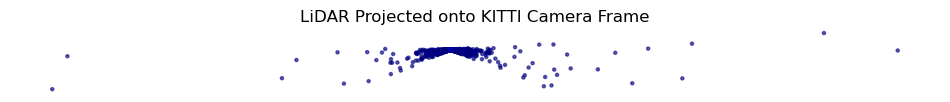

In [19]:
# Plot image
plt.figure(figsize=(12, 7))

# Show the Camera Image FIRST
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Ensure correct color format

# Overlay LiDAR points (Ensuring they are within image bounds)
plt.scatter(lidar_img_pts[:, 0], lidar_img_pts[:, 1], 
            c=lidar_cam_pts[:, 2], cmap="jet", s=5, alpha=0.6)  # Adjust size & transparency

# Remove axis
plt.axis("off")
plt.title("LiDAR Projected onto KITTI Camera Frame")
plt.show()


In [20]:
# Get image size
img_h, img_w, _ = img.shape

# Keep only points within image dimensions
valid_points = (lidar_img_pts[:, 0] >= 0) & (lidar_img_pts[:, 0] < img_w) & \
               (lidar_img_pts[:, 1] >= 0) & (lidar_img_pts[:, 1] < img_h)

lidar_img_pts = lidar_img_pts[valid_points]
lidar_cam_pts = lidar_cam_pts[valid_points]  # Keep corresponding depth values


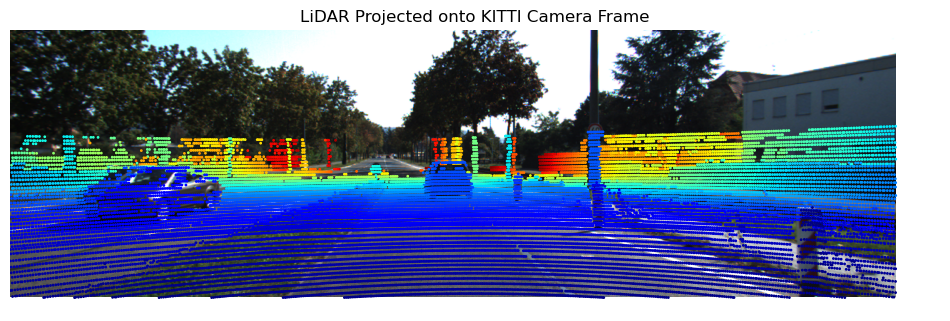

In [21]:
# Load the corresponding camera frame
img, lidar = load_kitti_frame(10, sequence="0010", split="training")

# Plot image
plt.figure(figsize=(12, 7))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.scatter(lidar_img_pts[:, 0], lidar_img_pts[:, 1], c=lidar_cam_pts[:, 2], cmap="jet", s=1)
plt.axis("off")
plt.title("LiDAR Projected onto KITTI Camera Frame")
plt.show()

# Object Detection

In [22]:
import torch
from ultralytics import YOLO
from sklearn.cluster import DBSCAN

In [23]:
# Load YOLO Model (Pre-trained)
yolo_model = YOLO("yolov8n.pt")

In [24]:
# Camera-Based Object Detection
def detect_objects_camera(img):
    results = yolo_model(img)
    return results

In [25]:
# LiDAR-Based Object Detection (DBSCAN Clustering)
def detect_objects_lidar(lidar_data):
    clustering = DBSCAN(eps=0.5, min_samples=5).fit(lidar_data)
    detected_objects = []
    for label in np.unique(clustering.labels_):
        if label != -1:
            points = lidar_data[clustering.labels_ == label]
            center = np.mean(points, axis=0)
            detected_objects.append(center)
    return detected_objects

# Object Tracking

In [26]:
from filterpy.kalman import KalmanFilter

# Initialize Kalman Filter for Object Tracking
def initialize_kalman():
    kf = KalmanFilter(dim_x=4, dim_z=2)
    kf.F = np.array([[1, 0, 1, 0],  
                     [0, 1, 0, 1],  
                     [0, 0, 1, 0],  
                     [0, 0, 0, 1]])  
    kf.H = np.array([[1, 0, 0, 0],  
                     [0, 1, 0, 0]])
    kf.P *= 1000
    kf.R = np.array([[5, 0], [0, 5]])  
    kf.Q = np.eye(4) * 0.1  
    return kf

# Affinity Computation and Data Association

In [27]:
from scipy.optimize import linear_sum_assignment

# Compute Affinity (IoU + 3D Distance)
def compute_affinity_matrix(tracked_objects, detections):
    affinity_matrix = np.zeros((len(tracked_objects), len(detections)))

    for i, track in enumerate(tracked_objects.values()):
        for j, detection in enumerate(detections):
            # iou_score = np.exp(-np.linalg.norm(track['position'] - detection))
            # affinity_matrix[i, j] = iou_score

            # Use a weighted combination of IoU and Euclidean distance
            distance_score = np.exp(-np.linalg.norm(track['position'] - detection))
            affinity_matrix[i, j] = distance_score  # Keep it in range [0,1]


    return affinity_matrix

# Data Association (Hungarian Algorithm)
def data_association(affinity_matrix):
    cost_matrix = 1 - affinity_matrix  
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    return list(zip(row_ind, col_ind))

# Tracking Pipeline 

In [28]:
# tracked_objects = {}
# def track_objects(num_frames=50, split="training", sequence="0010"):
#     global tracked_objects  # Ensure we update the global dictionary
# #def track_objects(num_frames=50, split="training"):
#     for frame_idx in range(num_frames):
#         print(f"\n🔹 Processing Frame {frame_idx} 🔹")

#         img, lidar_data = load_kitti_frame(frame_idx, sequence="0010", split=split)

#         # Parallel Detection
#         camera_objects = detect_objects_camera(img)
#         lidar_objects = detect_objects_lidar(lidar_data)

#         # Compute Affinity
#         affinity_matrix = compute_affinity_matrix(tracked_objects, lidar_objects)

#         # Perform Data Association
#         assignments = data_association(affinity_matrix)

#         # Update Existing Tracks
#         for track_idx, detection_idx in assignments:
#             if track_idx in tracked_objects:  # Ensure track exists before updating
#                 tracked_objects[track_idx]['position'] = lidar_objects[detection_idx]

#         # # Create New Tracks for Unmatched Detections
#         # unmatched_detections = set(range(len(lidar_objects))) - set([d for _, d in assignments])
#         # for detection_idx in unmatched_detections:
#         #     new_id = len(tracked_objects) + 1
#         #     tracked_objects[new_id] = {
#         #         'id': new_id,
#         #         'position': lidar_objects[detection_idx],
#         #         'kf': initialize_kalman()
#         #     }
        
#         #Fixing or Preventing New Track ID Inflation

#         unmatched_detections = set(range(len(lidar_objects))) - set([d for _, d in assignments])
#         for detection_idx in unmatched_detections:
#             # Check if the detection was already in tracked_objects (avoid duplicate tracking)
#             if not any(np.allclose(tracked_objects[tid]['position'], lidar_objects[detection_idx]) for tid in tracked_objects):
#                 new_id = len(tracked_objects) + 1
#                 tracked_objects[new_id] = {
#                     'id': new_id,
#                     'position': lidar_objects[detection_idx],
#                     'kf': initialize_kalman()
#                 }


#         print(f"Total Tracked Objects: {len(tracked_objects)}")

# # Run Tracking for Training Set
# track_objects(num_frames=100, split="training")




tracked_objects = {}

def track_objects(num_frames=50, split="training", sequence="0010"):
    global tracked_objects  # Ensure we update the global dictionary
    
    for frame_idx in range(num_frames):
        print(f"\n🔹 Processing Frame {frame_idx} 🔹")

        img, lidar_data = load_kitti_frame(frame_idx, sequence=sequence, split=split)

        # Parallel Detection
        camera_objects = detect_objects_camera(img)
        lidar_objects = detect_objects_lidar(lidar_data)

        # Compute Affinity
        affinity_matrix = compute_affinity_matrix(tracked_objects, lidar_objects)

        # Perform Data Association
        assignments = data_association(affinity_matrix)

        # Update Existing Tracks
        for track_idx, detection_idx in assignments:
            if track_idx in tracked_objects:  # Ensure track exists before updating
                tracked_objects[track_idx]['position'] = lidar_objects[detection_idx]
                tracked_objects[track_idx]['missed_frames'] = 0  # Reset missing frame count

        # Remove Old Tracks That Are Not Matched
        for track_id in list(tracked_objects.keys()):  # Convert to list to avoid runtime errors
            if tracked_objects[track_id]['missed_frames'] > 5:  # Remove if not seen for 5 frames
                del tracked_objects[track_id]
            else:
                tracked_objects[track_id]['missed_frames'] += 1  # Increase count if not matched

        # Fixing or Preventing New Track ID Inflation
        unmatched_detections = set(range(len(lidar_objects))) - set([d for _, d in assignments])
        for detection_idx in unmatched_detections:
            # Check if the detection was already in tracked_objects (avoid duplicate tracking)
            if not any(np.allclose(tracked_objects[tid]['position'], lidar_objects[detection_idx], atol=0.5) for tid in tracked_objects):
                new_id = max(tracked_objects.keys(), default=0) + 1  # Ensure unique IDs
                tracked_objects[new_id] = {
                    'id': new_id,
                    'position': lidar_objects[detection_idx],
                    'kf': initialize_kalman(),
                    'missed_frames': 0  # Track how long it's been missing
                }

        print(f"Total Tracked Objects: {len(tracked_objects)}")

# Run Tracking for Training Set
track_objects(num_frames=100, split="training")



🔹 Processing Frame 0 🔹

0: 224x640 5 cars, 54.9ms
Speed: 12.5ms preprocess, 54.9ms inference, 156.0ms postprocess per image at shape (1, 3, 224, 640)
Total Tracked Objects: 602

🔹 Processing Frame 1 🔹

0: 224x640 3 cars, 5.3ms
Speed: 1.0ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 640)
Total Tracked Objects: 620

🔹 Processing Frame 2 🔹

0: 224x640 3 cars, 5.3ms
Speed: 1.0ms preprocess, 5.3ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 640)
Total Tracked Objects: 620

🔹 Processing Frame 3 🔹

0: 224x640 1 person, 3 cars, 4.8ms
Speed: 0.9ms preprocess, 4.8ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 640)
Total Tracked Objects: 620

🔹 Processing Frame 4 🔹

0: 224x640 3 cars, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 640)
Total Tracked Objects: 620

🔹 Processing Frame 5 🔹

0: 224x640 4 cars, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 0.9ms postprocess per image 

In [1]:
print()